In [279]:
import json
import tweepy
import csv
import codecs

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import time
import os

import pandas as pd
from pandas.io.json import json_normalize as jn

import re,string

from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

import matplotlib.pyplot as plt

twitter_cred = dict()

twitter_cred['CONSUMER_KEY'] = '17XHiftb4Iu5hVAIh4NacWj9S'
twitter_cred['CONSUMER_SECRET'] = '8xAXhFsfnkiFjSFO5THqRO5J8x8lKSzC9J2GNPUSY7ZPb5z6Qv'
twitter_cred['ACCESS_KEY'] = '1392379572-FInzXaziEqyNCGc8jqtU9LwnFFlHYRpjoihZpiX'
twitter_cred['ACCESS_SECRET'] = 'JBDveSiUU6aXpwx8QkxYhXloDr9DyHn7ocqrqgWqwqctw'

In [2]:
with open('twitter_credentials.json', 'w') as secret_info:
    json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)
    

In [3]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

# Create the api endpoint

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

In [4]:

start_time = time.time()
class MyListener(StreamListener):
    def __init__(self, start_time, time_limit=60):
 
        self.time = start_time
        self.limit = time_limit
        self.tweet_data = []
        self.saveFile = open('raw_tweets.json', 'a', encoding='utf-8')
    
    def on_data(self, data):
        if (time.time() - self.time) < self.limit:
            try:
                self.tweet_data.append(data)
                saveFile = open('raw_tweets.json', 'w', encoding='utf-8')
                saveFile.write(u'[\n')
                saveFile.write(','.join(self.tweet_data))
                saveFile.write(u'\n]')
                saveFile.close()
                #exit()
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
                time.sleep(5)
                return True
        else:
            self.saveFile.close()
            return False 
                
 
        
    
    def on_error(self, status):
        print(status)
        return True


#if __name__ == '__main__':
    #MyListener = MyListener()
    #auth = OAuthHandler(consumer_key, consumer_secret)
    #auth.set_access_token(access_key, access_secret)
    #stream = Stream(auth,MyListener )
    #stream.filter(track=['#ML', '#Datascience', '#Arima'])



    
#This block of code opens an output file, writes the opening square bracket, writes the JSON data as text separated by commas, then inserts a closing square bracket, and closes the document. This is the standard JSON format with each Twitter object acting as an element in a JavaScript array. If you bring this into R or Python built-in parser and the json library can properly handle it.



In [5]:
#MyListener = MyListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
stream = Stream(auth,MyListener(start_time, time_limit=500) )
stream.filter(track=['#ML', '#Datascience', '#Arima'])


In [44]:
# with codecs.open('raw_tweets.json', 'r', 'utf-8') as f:
#     tweets = json.load(f, encoding='utf-8')
    

# list_tweets = [list(elem.values()) for elem in tweets]
# list_columns = list(tweets[0].keys())
# df = pd.io.json.json_normalize(tweets)
# df = pd.DataFrame(list_tweets, columns=list_columns)

In [32]:
# data=open('raw_tweets.json', 'r', encoding='utf-8')
# df = pandas.io.json.json_normalize(data)
# df.columns = df.columns.map(lambda x: x.split(".")[-1])
# df.head()

with open('raw_tweets.json', 'r', encoding="utf-8") as json_file:
    json_work = json.load(json_file)
    
df = pd.io.json.json_normalize(json_work)
df.head()

,contributors,coordinates,created_at,display_text_range,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,extended_entities.media,...,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified
0,None,None,Sun Apr 14 02:59:00 +0000 2019,NaN,[],NaN,[],"[{'url': 'https://t.co/3Rni1Ohlli', 'expanded_...","[{'screen_name': 'antgrasso', 'name': 'Antonio...",NaN,...,333333,True,False,Merckxcycling,161168,None,none,None,None,False
1,None,None,Sun Apr 14 02:59:05 +0000 2019,NaN,"[{'text': 'abdsc', 'indices': [63, 69]}, {'tex...",NaN,[],"[{'url': 'https://t.co/qbFUB8BRdA', 'expanded_...","[{'screen_name': 'KirkDBorne', 'name': 'Kirk B...",NaN,...,333333,True,False,PortfolioRisk,2075,None,none,http://www.peachfc.com,None,False
2,None,None,Sun Apr 14 02:59:14 +0000 2019,NaN,"[{'text': 'Techno', 'indices': [54, 61]}, {'te...",NaN,[],[],"[{'screen_name': 'Mc_Snz', 'name': 'Mc_Snz', '...",NaN,...,333333,True,False,Soulmusic_promo,30205,None,none,http://www.50djs50states.com,None,False
3,None,None,Sun Apr 14 02:59:22 +0000 2019,NaN,"[{'text': 'DataScience', 'indices': [34, 46]}]",NaN,[],[],"[{'screen_name': 'Ronald_vanLoon', 'name': 'Ro...",NaN,...,333333,True,False,Merckxcycling,161171,None,none,None,None,False
4,None,None,Sun Apr 14 02:59:29 +0000 2019,NaN,[],NaN,[],[],"[{'screen_name': 'antgrasso', 'name': 'Antonio...",NaN,...,333333,True,False,ScottGuliford,13220,None,none,None,None,False


In [227]:
# list_columns = list(json_work[0].keys())
# list_tweets = [list(elem.values()) for elem in json_work]


#df.to_csv("naya.csv", index=False)

In [247]:
df_clean=df.iloc[:,208]

In [248]:
df_cleans=pd.DataFrame({'text':df_clean})

In [249]:
def remove_RT(x):
    if x=="RT ":
        return " "
        #return str(x.replace('b\'RT ',''))

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    #cleanString   = re.sub('\W+','', string )
    for link in links:
        text = text.replace(link[0], ', ')    
        #text = text.replace(cleanString, '')
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

In [250]:
df_cleans['TextNoMentions']=df_cleans['text'].str.replace('RT', ' ')

In [251]:
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].str.replace('#', '', case=False)

In [252]:
#df_cleans['TextNoLinks']=df_cleans['text'].apply(strip_links)
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].str.replace('http\S+|www.\S+', '', case=False)

In [253]:
#df_cleans['TextNoEntities']=df_cleans['TextNoLinks'].apply(strip_all_entities)
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].apply(strip_all_entities)

In [254]:
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].apply(removeNonAscii)

In [269]:
a=df_cleans['TextNoMentions'].unique()

In [270]:
a=a.tolist()

In [271]:
df_cleaner=pd.DataFrame({'text':a})

In [272]:
df_cleaner.head()

,text
0,Businesses Will Need One Million Data Scientis...
1,3 Types of Regression abdsc DataScience Statis...
2,Snz Pivotal moments in internet music history ...
3,vanLoon The Future of DataScience in One Pictu...
4,Data Science is not a single discipline but a ...


In [280]:
# Lets check the avg number of words in text written by each author in a histogram 
def word_count(row):
    """function to calculate the count of words in a given text """
    text = row['text']
    text_splited = text.split(' ')
    word_count = text_splited.__len__()
    return word_count

df_cleaner['word_count'] = ''
df_cleaner['word_count'] = df_cleaner.apply(lambda row: word_count(row), axis =1)

(-0.5, 399.5, 199.5, -0.5)

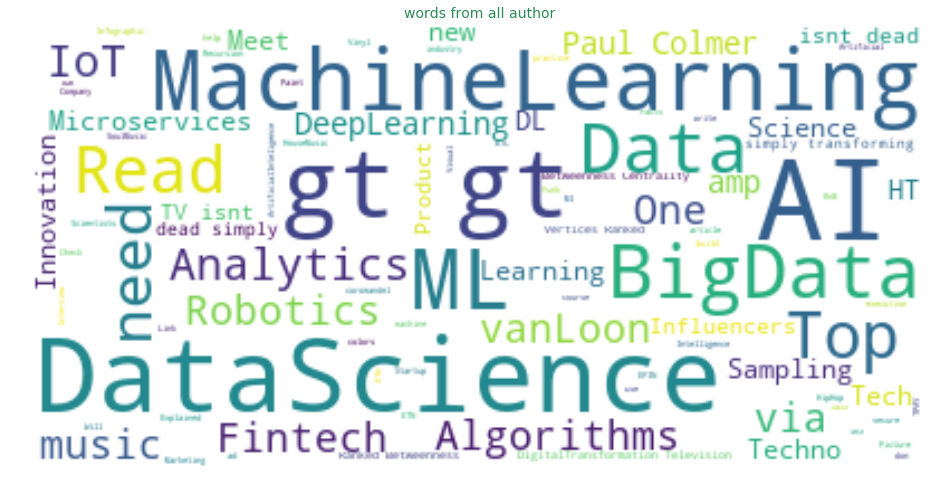

In [281]:
#mws = df_cleaner["text"].values

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)
# generate word cloud
wc.generate(" ".join(df_cleaner.text.values))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14,color='seagreen')
plt.axis("off")

In [255]:
df_cleans.head()
df_cleans.to_csv("new.csv", index=False)

In [ ]:
#helps in reading the file
with open('mytweets.json', 'r') as f:
    line = f.readline() # read only the first tweet/line
    tweet = json.loads(line) # load it as Python dict
    print(json.dumps(tweet, indent=4)) # pretty-print


In [ ]:
from operator import itemgetter        
import csv
import json

header = ['text', 'username', 'created_at']
required_cols = itemgetter(*header)

with open('python.json') as f_input, open('output.csv', 'wb') as f_output:
    csv_output = csv.writer(f_output)
    csv_output.writerow(header)

    for row in f_input:
        if row.strip():
            csv_output.writerow(required_cols(json.loads(row)))


In [ ]:
def out_tweets(tweets_scrapped):
    
    outtweets = [[tweet.id_str, tweet.created_at,tweet.text.encode('utf-8').decode("utf-8"),tweet.user.name,tweet.user.screen_name,tweet.user.friends_count,tweet.user.followers_count,tweet.retweet_count,tweet.favorite_count] for tweet in tweets_scrapped]
    return outtweets

In [ ]:
def csv_tweets(outtweets,hashtag):
    tweet_csv_name=' tweets with hashtag #' + hashtag+'.csv'
    with open(tweet_csv_name, 'w', encoding='utf8') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'created_at', 'text','user','screen_name','friends_count','followers_count','retweet_count','favorite_count'])
    
        writer.writerows(outtweets)